In [28]:
import karhunenLoeve as kl
from matplotlib import pyplot as plt
from matplotlib import colormaps
from matplotlib import colors
import numpy as np
import time

Graph settings:

In [ ]:
plt.rc('font', family='Times', size=12)  # Rodina a velikost písma
plt.rc('figure', figsize=(10, 6), dpi=100)  # Velikost a rozlišení obrázku
plt.rc('text', usetex=True)

testing of integrals in the Galerkin Method for Spectral Decomposition

## 1D
#### Calculation of W matrix
should be identity matrix due to orthogonality

[[ 1.00000000e+00  7.07767178e-16 -4.59875193e-15  5.29784550e-15]
 [ 7.07767178e-16  1.00000000e+00  5.26510259e-15 -5.97178557e-15]
 [-4.59875193e-15  5.26510259e-15  1.00000000e+00  5.12263842e-15]
 [ 5.29784550e-15 -5.97178557e-15  5.12263842e-15  1.00000000e+00]]


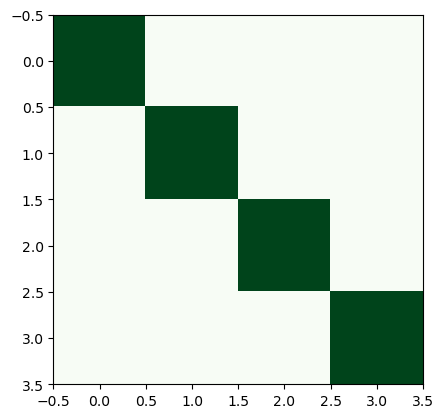

In [29]:

l = lambda x : kl.integ.legendre_normal(x, 100)

matrix_size = 4
matrix = np.zeros((matrix_size,matrix_size))
for i in range(matrix_size):
    for j in range(matrix_size):
        matrix[i,j] = kl.integ.quadrature(lambda x : l(x)[i]*l(x)[j], 100)
print(matrix)

# plot
fig, ax = plt.subplots()


ax.imshow(matrix, cmap=colormaps['Greens'])
plt.show()

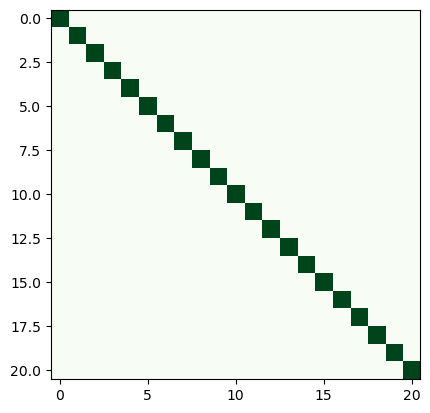

In [30]:
l = lambda x : kl.integ.legendre_normal(x, 20)

n = 50


nodes, weights = kl.integ.nodes_weights(n)

values = l(nodes)


matrix = ((values * weights) @ values.T)
#print(values)
#print(values * weights)


# plot
fig, ax = plt.subplots()

ax.imshow(matrix, cmap=colormaps['Greens'])
plt.show()


with interval <a,b>:

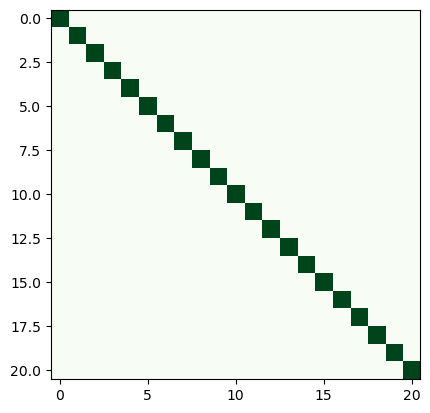

In [31]:
a = 0
b = 5
l = lambda x : kl.integ.legendre_normal(((a+b)/(a-b) + (2/(b-a))*x), 20)

n = 50


nodes, weights = kl.integ.nodes_weights(n)

nodes = (a+b)/2 + (b-a)/2*nodes
weights = weights * (b-a)/2

values = l(nodes)


matrix = ((values * weights) @ values.T)
#print(values)
#print(values * weights)

# plot
fig, ax = plt.subplots()

ax.imshow(matrix, cmap=colormaps['Greens'])
plt.show()

## Covariance function

Matern covariance function

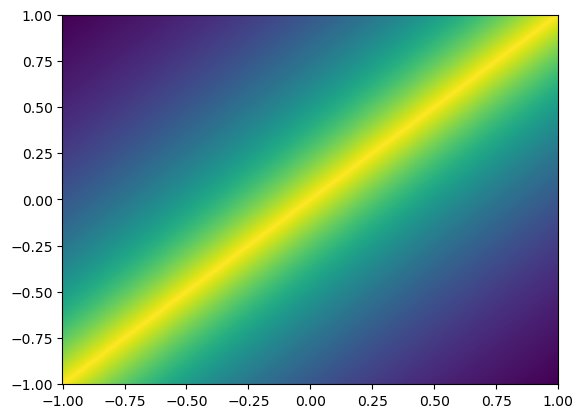

In [32]:
cov = lambda x,y : np.exp(-np.abs(x-y))
x = np.linspace(-1, 1, 1000)
y = np.linspace(-1, 1, 1000)
x,y = np.meshgrid(x,y)

plt.pcolormesh(x, y, cov(x,y))
plt.show()

Covariance function exp 

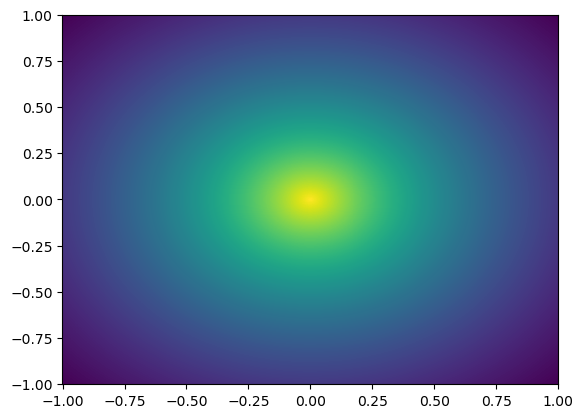

In [33]:
lamb = 1
cov = lambda x,y : np.exp(-np.sqrt((x)**2 + (y)**2)/lamb)
x = np.linspace(-1, 1, 1000)
y = np.linspace(-1, 1, 1000)
x,y = np.meshgrid(x,y)

plt.pcolormesh(x, y, cov(x,y))
plt.show()

Covariance function exp^2

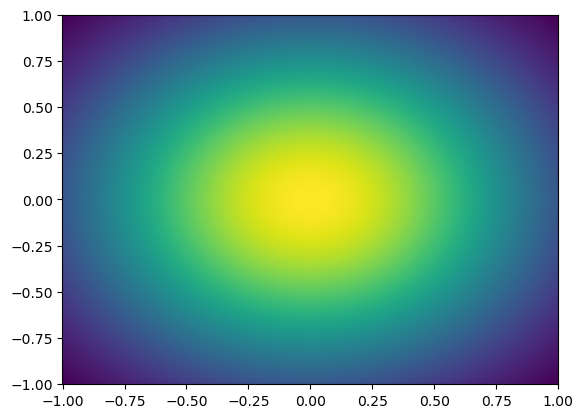

In [34]:
lamb = 1
cov = lambda x,y : np.exp(-((x)**2 + (y)**2)/lamb)
x = np.linspace(-1, 1, 1000)
y = np.linspace(-1, 1, 1000)
x,y = np.meshgrid(x,y)

plt.pcolormesh(x, y, cov(x,y))
plt.show()

### Intagral with Covariance funtion

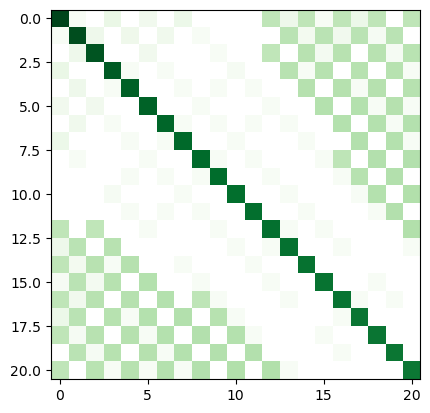

In [35]:
l = lambda x : kl.integ.legendre_normal(x, 20)
cov = lambda x,y : np.exp(-np.abs(x-y))

n = 100


nodes, weights = kl.integ.nodes_weights(n)

nodesx, nodesy = np.meshgrid(nodes,nodes)
values = l(nodes)

#print(cov(nodesx, nodesy))

A = (values * weights)
matrix = A @ (cov(nodesx, nodesy) )@ A.T
#print(matrix)

# plot
fig, ax = plt.subplots()

#ax.imshow(matrix, cmap=colormaps['Greens'])
ax.imshow(matrix, cmap=colormaps['Greens'], norm=colors.LogNorm())
plt.show()

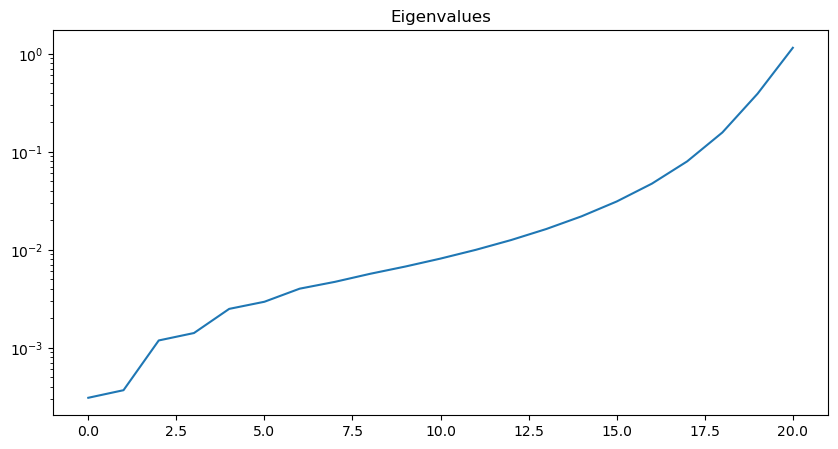

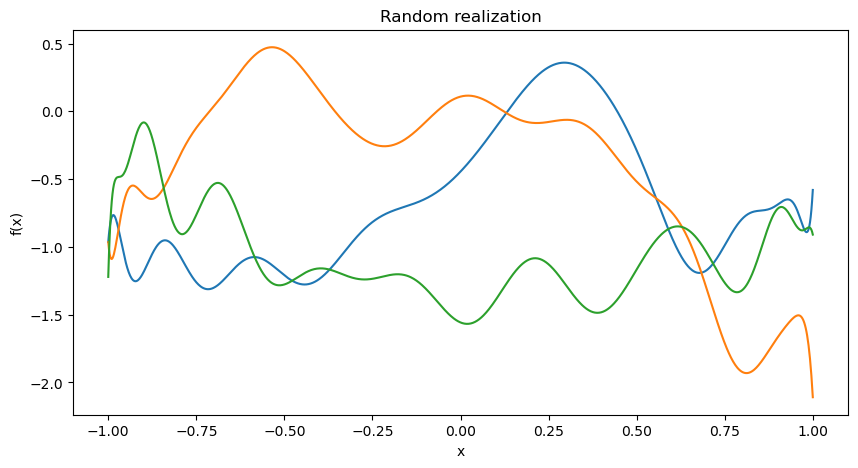

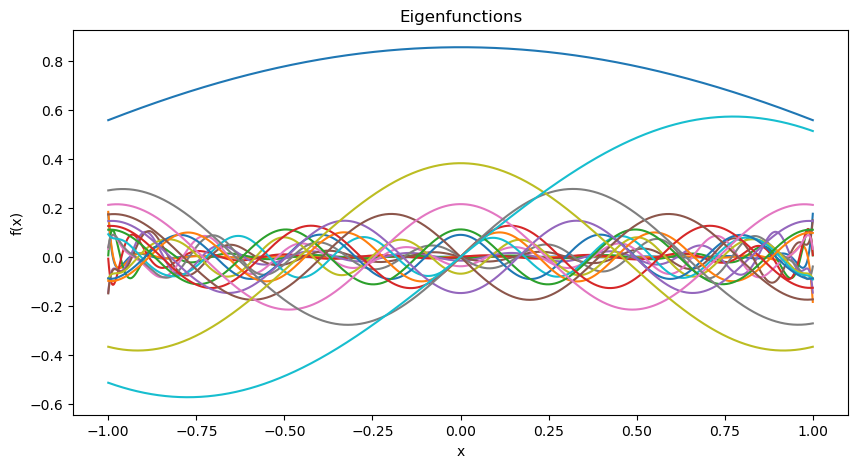

In [46]:
# eigendecomposition of matrix
eigenvalues, eigenvectors = np.linalg.eigh(matrix)
x_axis = np.linspace(-1, 1, 1000)
values = l(x_axis)
eigenvectors_functions = (values.T @ eigenvectors) * np.sqrt(np.maximum(eigenvalues, 0))

# random realization
n = eigenvectors_functions.shape[1]

plt.figure(figsize=(10, 5))
plt.title('Eigenvalues')
plt.plot(eigenvalues)
plt.yscale("log")
plt.show()

plt.figure(figsize=(10, 5))
for i in range(3):
    realisation = np.random.normal(size=n)
    realisation = eigenvectors_functions @ realisation

    plt.plot(x_axis, realisation)

plt.title('Random realization')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()


# eigenfunctions visualization
plt.figure(figsize=(10, 5))
for fnc in eigenvectors_functions.T:
    plt.plot(x_axis, fnc)
plt.title('Eigenfunctions')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

(21, 50)


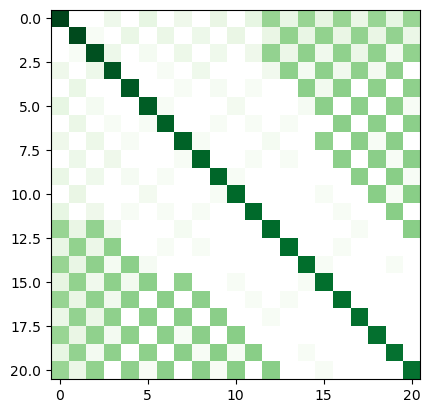

In [16]:
a = -2
b = 1
l = lambda x : kl.integ.legendre_normal(x, 20)
cov = lambda x,y : np.exp(-np.abs(x-y))

n = 50


nodes, weights = kl.integ.nodes_weights(n)

nodes = (a+b)/2 + (b-a)/2*nodes
weights = weights * (b-a)/2


nodesx, nodesy = np.meshgrid(nodes,nodes)
values = l((a+b)/(a-b) + (2/(b-a))*nodes)

#print(cov(nodesx, nodesy))
A = (values* weights)
matrix = A @ cov(nodesx, nodesy) @ A.T
#print(matrix)

#print(weights.shape)
#print(nodes.shape)
print(values.shape)
#print(cov(nodesx, nodesy).shape)
#print(matrix.shape)



# plot
fig, ax = plt.subplots()

#ax.imshow(matrix, cmap=colormaps['Greens'])
ax.imshow(matrix, cmap=colormaps['Greens'], norm=colors.LogNorm())
plt.show()

(21, 1000) (21,) (21, 21) (1000, 21)
(1000, 21) (21,)


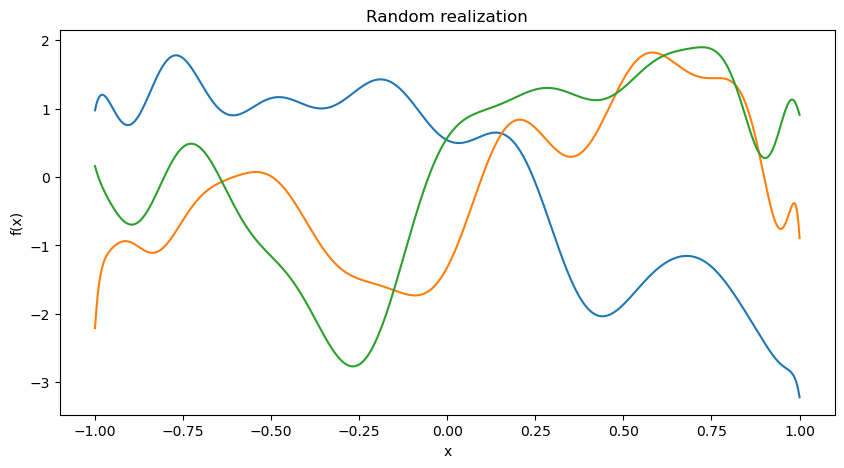

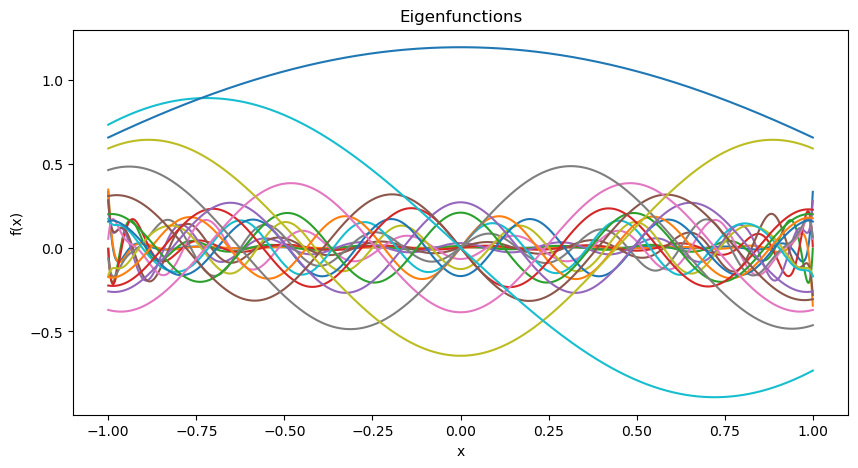

In [17]:
# eigendecomposition of matrix
eigenvalues, eigenvectors = np.linalg.eigh(matrix)
x_axis = np.linspace(-1, 1, 1000)
values = l(x_axis)
eigenvectors_functions = (values.T @ eigenvectors) * np.sqrt(np.maximum(eigenvalues, 0))
print(values.shape, eigenvalues.shape, eigenvectors.shape, eigenvectors_functions.shape)
print((values.T @ eigenvectors).shape, np.sqrt(np.maximum(eigenvalues, 0)).shape)

# random realization
n = eigenvectors_functions.shape[1]

plt.figure(figsize=(10, 5))
for i in range(3):
    realisation = np.random.normal(size=n)
    realisation = eigenvectors_functions @ realisation

    plt.plot(x_axis, realisation)


plt.title('Random realization')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()


# eigenfunctions visualization
plt.figure(figsize=(10, 5))
for fnc in eigenvectors_functions.T:
    plt.plot(x_axis, fnc)
plt.title('Eigenfunctions')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

---
## 2D

Obtaining a 4D tensor A and making it into 2D tensor

In [18]:
poly_count = 18
l = lambda x: kl.integ.legendre_normal(x, poly_count)
#cov = lambda x1, x2, y1, y2 : np.exp(-np.abs( np.sqrt( (x1-x2)**2+(y1-y2)**2 )))

n = 100


nodes, weights = kl.integ.nodes_weights(n)

#nodesx1, nodesx2, nodesy1, nodesy2 = np.meshgrid(nodes, nodes, nodes, nodes)
nodesx1 = np.reshape(nodes, (-1, 1, 1, 1))
nodesy1 = np.reshape(nodes, (1, -1, 1, 1))
nodesx2 = np.reshape(nodes, (1, 1, -1, 1))
nodesy2 = np.reshape(nodes, (1, 1, 1, -1))
values = l(nodes)

#print(cov(nodesx1, nodesx2, nodesy1, nodesy2).shape)
#print(values.shape)
dist_sq = (nodesx1 - nodesx2)**2 + (nodesy1 - nodesy2)**2
lamb = 10
C_tensor = np.exp(-np.sqrt(dist_sq)/lamb)


#matrix = (values* weights) @ cov(nodesx1, nodesx2, nodesy1, nodesy2) @ (values.T * weights[:, np.newaxis])
PW = (values* weights)
A_tensor = np.einsum('kp,lq,pqrs,ir,js->klij', PW, PW, C_tensor, PW, PW, optimize=True)
A_tensor.shape
A_matrix = np.reshape(A_tensor, ((poly_count+1)**2,(poly_count+1)**2))

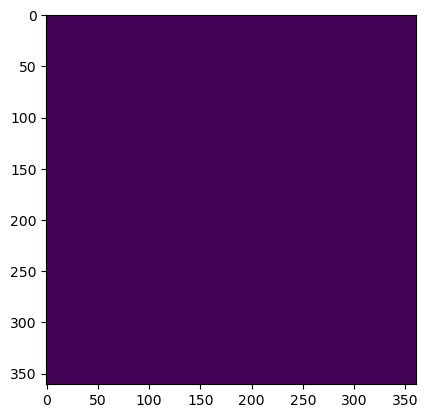

In [19]:
plt.imshow(A_matrix)

Making eigenfunctions (inefficient):

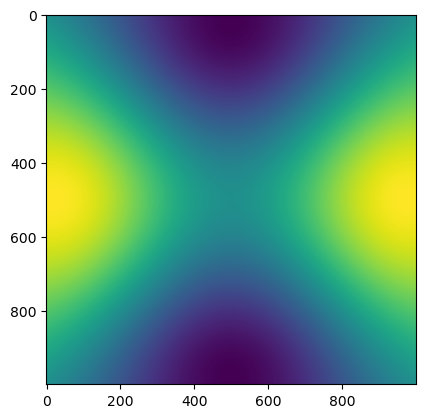

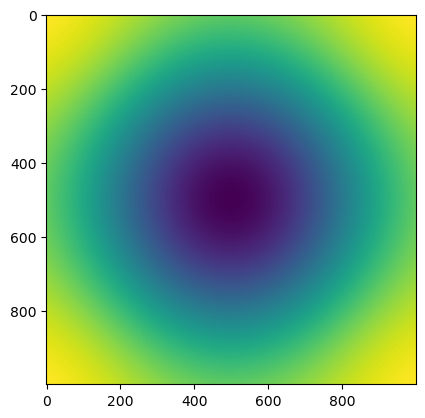

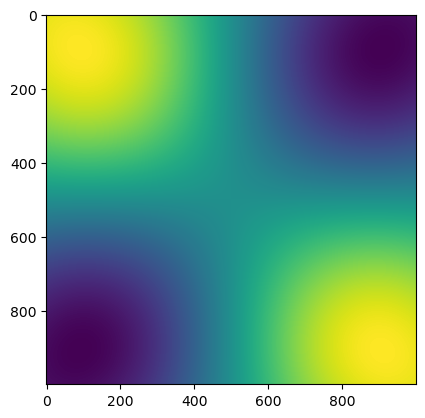

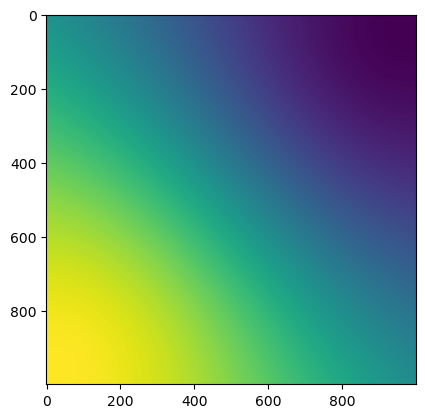

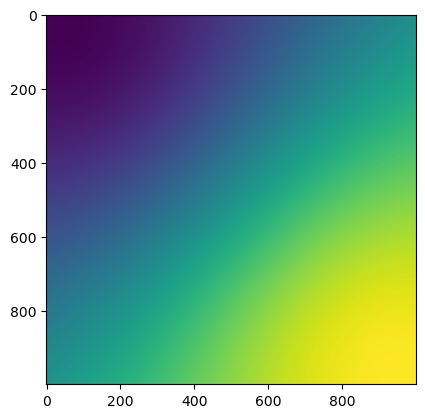

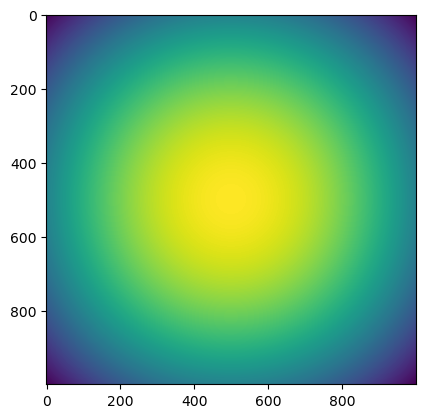

In [20]:
eigenvalues, eigenvectors = np.linalg.eigh(A_matrix)
#A = 1
#print((eigenvalues[A] * eigenvectors[:,A])- (A_matrix @ eigenvectors[:,A]))
x_axis = np.linspace(-1, 1, 1000)
values = l(x_axis)
for eivec in range((poly_count+1)**2-6,(poly_count+1)**2):
    sum = 0
    for i in range(len(values)):
        for j in range(len(values)):
            sum+=values[i]*values[j][:, np.newaxis]*eigenvectors[i*(poly_count+1)+j,eivec] *np.sqrt(np.maximum(eigenvalues[eivec], 0))
    plt.imshow(sum)
    plt.show()



Making eigenfunctions:

In [21]:
eigenvalues, eigenvectors = np.linalg.eigh(A_matrix)
#A = 1
#print((eigenvalues[A] * eigenvectors[:,A])- (A_matrix @ eigenvectors[:,A]))
x_axis = np.linspace(-1, 1, 1000)
values = l(x_axis)

# Perform broadcasted multiplication
V1 = values[:, np.newaxis, np.newaxis, :] # Shape (L, 1, 1, N)
V2 = values[np.newaxis, :, :, np.newaxis] # Shape (1, L, N, 1)
V = V1 * V2
V = np.reshape(V, (len(V)**2,len(x_axis),len(x_axis)))
#print(V.shape)
eigenvectors_functions = (np.einsum('ijk,in->njk', V, eigenvectors, optimize=True).T * np.sqrt(np.maximum(eigenvalues, 0))).T
    

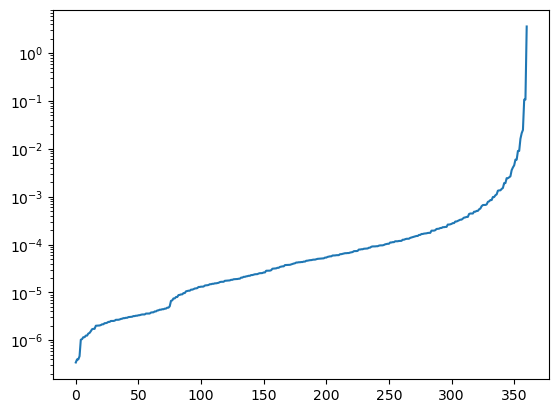

In [26]:
plt.plot(eigenvalues)
plt.yscale('log')
plt.show()

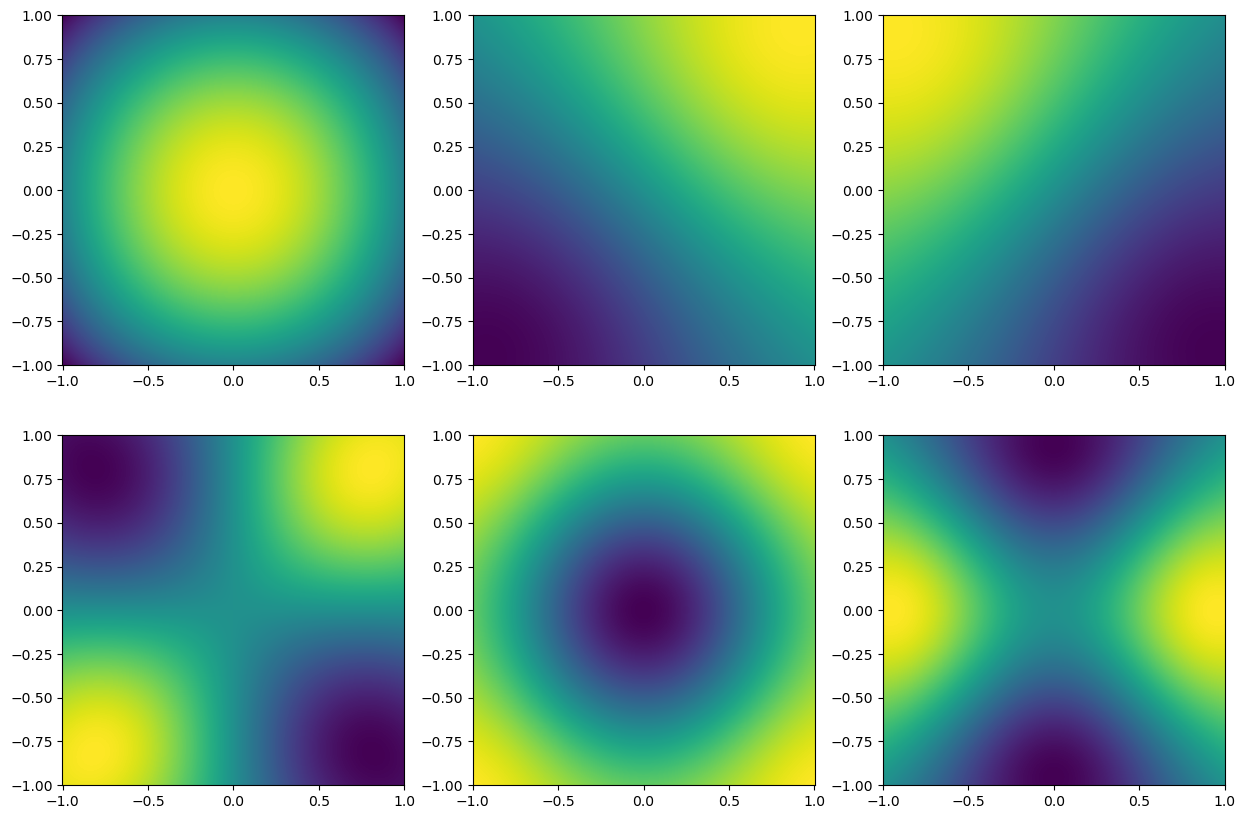

In [22]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for i in range(6):
    if(i<3): 
        axs[0,i].pcolormesh(x_axis, x_axis, eigenvectors_functions[-i-1])
    else:
        axs[1,i-3].pcolormesh(x_axis, x_axis, eigenvectors_functions[-i-1])
plt.show()

Random fields samples:

<Figure size 1000x500 with 0 Axes>

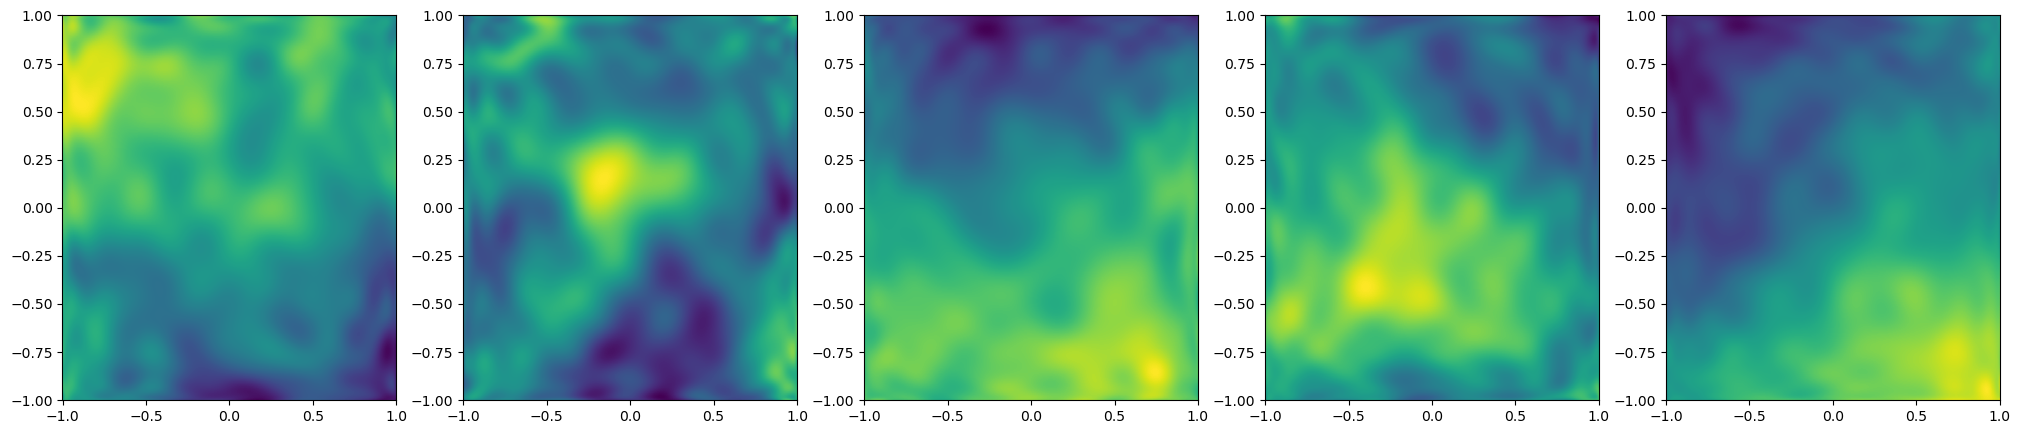

In [14]:
# random realization
n = eigenvectors_functions.shape[0]

plt.figure(figsize=(10, 5))

fig, axs = plt.subplots(1, 5, figsize=(25, 5))
for i in range(5):
    realisation = np.random.normal(size=n)
    #print(realisation.shape)
    #print(eigenvectors_functions.T.shape)
    realisation = eigenvectors_functions.T @ realisation

    axs[i].pcolormesh(x_axis, x_axis, realisation)
    
plt.show()
#
#
#plt.title('Random realization')
#plt.xlabel('x')
#plt.ylabel('f(x)')

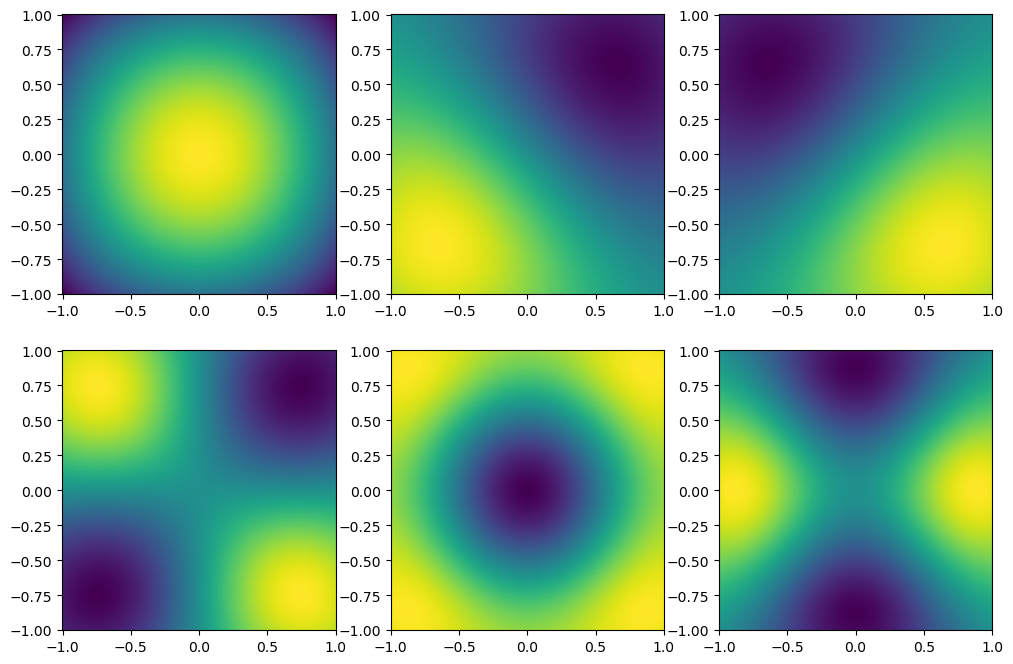

In [15]:
x = np.linspace(-1, 1, 500)


def C(x1,x2,y1,y2):
    dist_sq = (x1 - x2)**2 + (y1 - y2)**2
    return np.exp(-np.sqrt(dist_sq))
eigenfunctions = kl.get_eigenfuntions(x, C, 30, 80)
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

for i in range(6):
    if(i<3): 
        axs[0,i].pcolormesh(x, x, eigenfunctions[-i-1])
    else:
        axs[1,i-3].pcolormesh(x, x, eigenfunctions[-i-1])
plt.show()

<Figure size 1000x500 with 0 Axes>

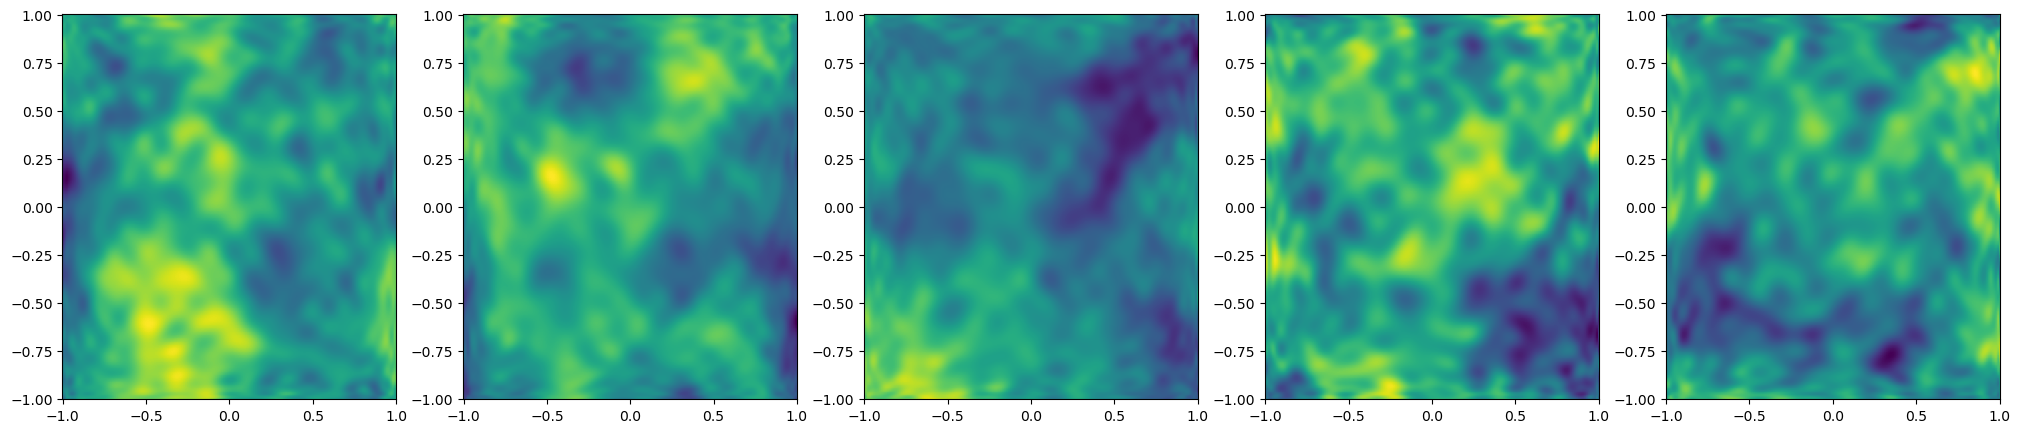

In [16]:
n = eigenfunctions.shape[0]

plt.figure(figsize=(10, 5))

fig, axs = plt.subplots(1, 5, figsize=(25, 5))
for i in range(5):
    realisation = kl.sample_normal(eigenfunctions)

    axs[i].pcolormesh(x, x, realisation)
    
plt.show()

Lets see how of the integrals of same polynomials with a C_tensor look like as graphs

In [17]:
l = lambda x : kl.integ.legendre_normal(x, 100)

In [18]:
n = 10

lamb = 10
aprox = []
node_range = range(20,100)
#node_range = range(1,n+20)
for node_count in node_range:
    nodes, weights = kl.integ.nodes_weights(node_count)
    nodesx = np.reshape(nodes, (-1, 1))
    nodesy = np.reshape(nodes, (1, -1))
    dist_sq = (nodesx)**2 + (nodesy)**2
    C_tensor = np.exp(-np.sqrt(dist_sq)/lamb)
    #int_aprox = np.einsum('j,jk,k->', l(nodes)[n], C_tensor, l(nodes)[n])
    int_aprox =(l(nodes)[n]*weights) @ C_tensor @ (l(nodes)[n]*weights)
    aprox.append(int_aprox)

Integral result:

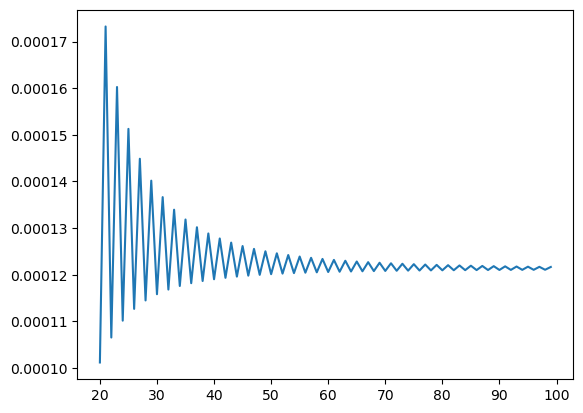

In [19]:
plt.plot(node_range,aprox)
plt.show()

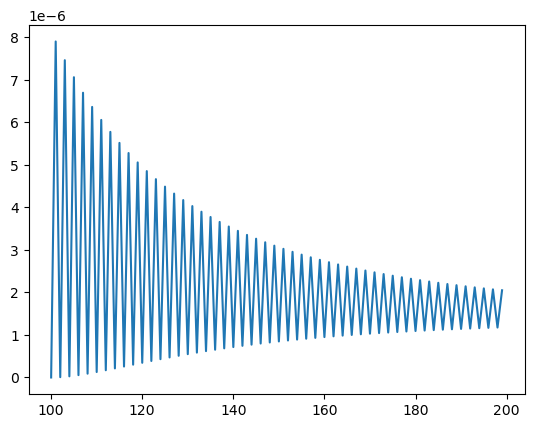

In [20]:
n = 100

lamb = 1
aprox = []
node_range = range(100,200)
#node_range = range(250,300)
for node_count in node_range:
    nodes, weights = kl.integ.nodes_weights(node_count)
    nodesx = np.reshape(nodes, (-1, 1))
    nodesy = np.reshape(nodes, (1, -1))
    dist_sq = (nodesx)**2 + (nodesy)**2
    C_tensor = np.exp(-np.sqrt(dist_sq)/lamb)
    #int_aprox = np.einsum('j,jk,k->', l(nodes)[n], C_tensor, l(nodes)[n])
    int_aprox =(l(nodes)[n]*weights) @ C_tensor @ (l(nodes)[n]*weights)
    aprox.append(int_aprox)
plt.plot(node_range,aprox)
plt.show()

### Lets have a different C

In [21]:
n = 4

lamb = 1
aprox = []
difference = []
node_range = range(15,100)
#node_range = range(1,n+20)
for node_count in node_range:
    nodes, weights = kl.integ.nodes_weights(node_count)
    nodesx = np.reshape(nodes, (-1, 1))
    nodesy = np.reshape(nodes, (1, -1))
    dist_sq = (nodesx)**2 + (nodesy)**2
    C_tensor = np.exp(-dist_sq/lamb)
    #int_aprox = np.einsum('j,jk,k->', l(nodes)[n], C_tensor, l(nodes)[n])
    int_aprox =(l(nodes)[n]*weights) @ C_tensor @ (l(nodes)[n]*weights)
    aprox.append(int_aprox)
    difference.append(np.abs(int_aprox-0.0164274897245295915177756431842263468086376299790787366359421403395269788))

Integral result:

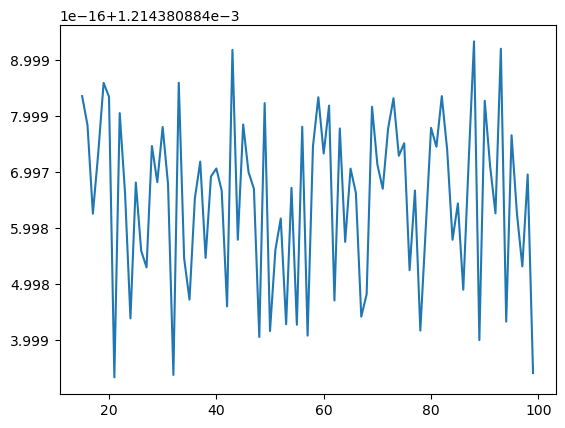

In [22]:
plt.plot(node_range,aprox)
plt.show()

Difference from real value:

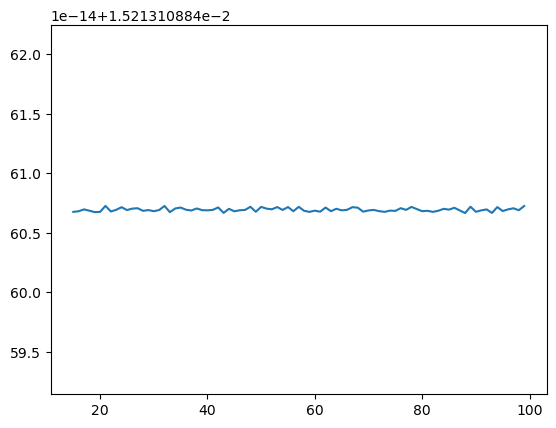

In [23]:
plt.plot(node_range,difference)
plt.show()

In [32]:
n = 4

lamb = 1
aprox = []
difference = []
times = []
node_range = range(15,500)
#node_range = range(1,n+20)
for node_count in node_range:
    starttime = time.time()
    nodes, weights = kl.integ.nodes_weights(node_count)
    dist_sq = (nodes)**2
    C_tensor = np.exp(-dist_sq/lamb)
    #int_aprox = np.einsum('j,jk,k->', l(nodes)[n], C_tensor, l(nodes)[n])
    int_aprox =((l(nodes)[n]*weights) @ C_tensor)**2
    endtime = time.time()

    aprox.append(int_aprox)
    difference.append(np.abs(int_aprox-0.0164274897245295915177756431842263468086376299790787366359421403395269788))
    times.append(endtime-starttime)


Integral result:

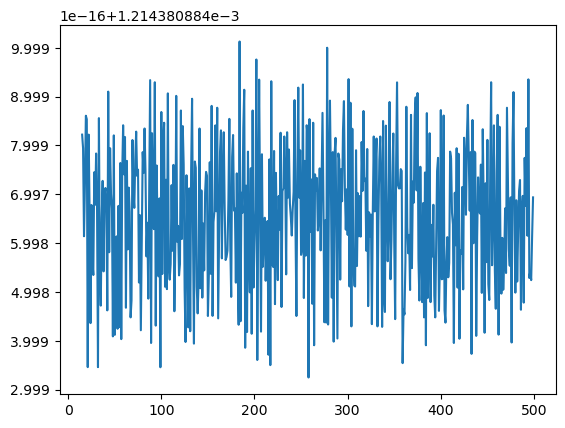

In [34]:
plt.plot(node_range,aprox)
plt.show()

Difference from real value:

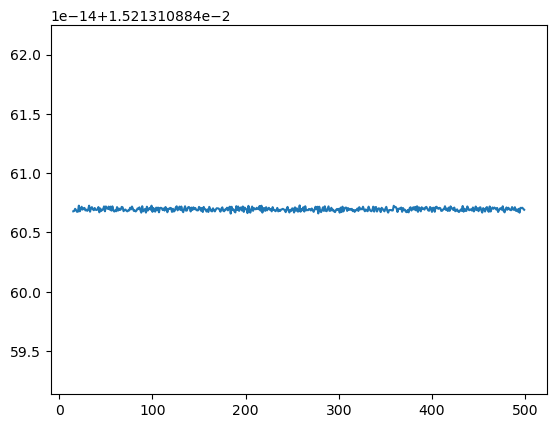

In [35]:
plt.plot(node_range,difference)
plt.show()

Time graph

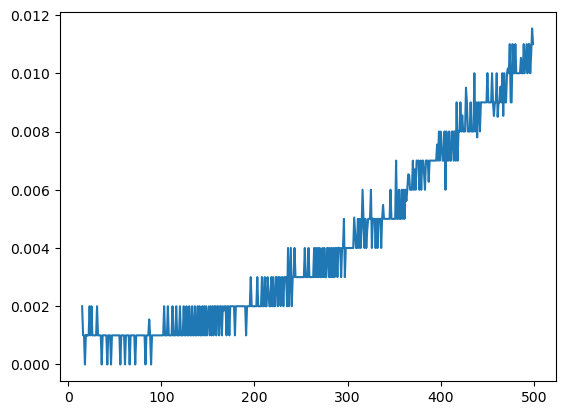

In [36]:
plt.plot(node_range,times)
plt.show()